In [152]:
import scipy.integrate
import numpy as np

from matplotlib import pyplot
%matplotlib inline

input - **Fluid and Atmosphere properties**

In [153]:
I = 500                          # Incident beam radiation in W m-2
U_l = 7                          # Overall heat loss coefficient W m-1 K-1
T_r = 250 + 273                       # Receiver wall temperature K
T_a = 32 + 273                        # Ambient Temperature K

input - **Material Properties**

In [154]:
rho_m = 0.85                     # Reflectivity of the mirror
tau_e = 0.9                      # Transmitivity of the envelope
alpha_r = 0.9                    # Absorptivity of the receiver


input - **Dimensions**

In [155]:
W_a = 0.8                    # width of the aperture in m

L = 1.25                          # length of the aperture in m
f = 0.2

D_ro = 0.0128                    # outer diameter of the receiver tube in m


sigma_sun = 0.0025
sigma_slope = 0.004
sigma_mirror = 0.002

beta = 0.18*np.pi / 180          # misalignment angle in rad
dr = 0.002                     # vertical disp of receiver in m
phi_r = np.pi / 2              # rim angle in rad

theta = 0                         # incident angle in rad


# C = W_a / (np.pi* D_ro)

Calculation - **Intercept factor**

In [156]:
def InterceptFactorInputs( W_a, D_ro, sigma_sun, sigma_slope, sigma_mirror, beta, dr, phi_r):
    "Determines the input for findInterceptFactor and call it"
    
    C = W_a / (np.pi* D_ro)
    sigma = np.sqrt(np.power(sigma_sun, 2) + 4*np.power(sigma_slope, 2) + np.power(sigma_mirror, 2))
    
#     print (sigma, C)
    sigma = 0.01
    sigmaSTAR = sigma * C
    betaSTAR = beta * C
    dSTAR = dr / D_ro
    
#     print (C)
    return InterceptFactor( sigmaSTAR, betaSTAR, dSTAR, phi_r)

In [157]:
def InterceptFactor( sigmaSTAR, betaSTAR, dSTAR, phi_r ):
    "Computes the intercept factor from the given parameters"
    
    EF = lambda phi: float(((scipy.special.erf(( np.sin(phi_r)*(1 + np.cos(phi))*(1 - 2*dSTAR*np.sin(phi)) - (np.pi*betaSTAR*(1 + np.cos(phi_r)))) / (np.sqrt(2)*np.pi*sigmaSTAR*(1 + np.cos(phi_r)))) - scipy.special.erf(-( np.sin(phi_r)*(1 + np.cos(phi))*(1 + 2*dSTAR*np.sin(phi)) + (np.pi*betaSTAR*(1 + np.cos(phi_r)))) / (np.sqrt(2)*np.pi*sigmaSTAR*(1 + np.cos(phi_r))))) / (1 + np.cos(phi))))
    
    integrated_result = scipy.integrate.quad(EF, 0, phi_r)
    IF = ((1 + np.cos(phi_r)) / (2*np.sin(phi_r))) * integrated_result[0]
    
    return IF

Calculation - **Geometric factor**

In [158]:
def GeometricFactor( W_a, f, L):
    "Determines the Geometric Factor"
    
    h_p = f
    
    GF = (2/3 * W_a * h_p + f * W_a * (1 + np.power(W_a, 2) / (48*np.power(f, 2)))) / (W_a*L)
    
    return GF

Calculation - **Optical Efficiency**

In [159]:
def OpticalEfficiency( rho_m, tau_e, alpha_r, gamma, theta, A_f):
    "Determines the Optical Efficiency"
    
    eta_o = rho_m * tau_e * alpha_r * gamma * (1 - A_f*np.tan(theta)) * np.cos(theta)
    
    return eta_o

In [160]:
gamma = InterceptFactorInputs( W_a, D_ro, sigma_sun, sigma_slope, sigma_mirror, beta, dr, phi_r)

A_f = GeometricFactor( W_a, f, L)

eta_o = OpticalEfficiency( rho_m, tau_e, alpha_r, gamma, theta, A_f)

Calculation - **Thermal Efficiency**

In [161]:
def ThermalEfficiency( eta_o, I, W_a, U_l, T_r, T_a):
    "Determines the thermal Efficiency"
    
    D_ro = 0.0128
    C = W_a / (np.pi* D_ro)
    
    eta_t = eta_o - ((U_l*(T_r - T_a))/(I*C))
    
    return eta_t

In [162]:
print (gamma, A_f, eta_o)

0.92374188726 0.32 0.635996289378


Plot - **Intercept factor** vs **Aperture width**

F:\HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
F:\HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


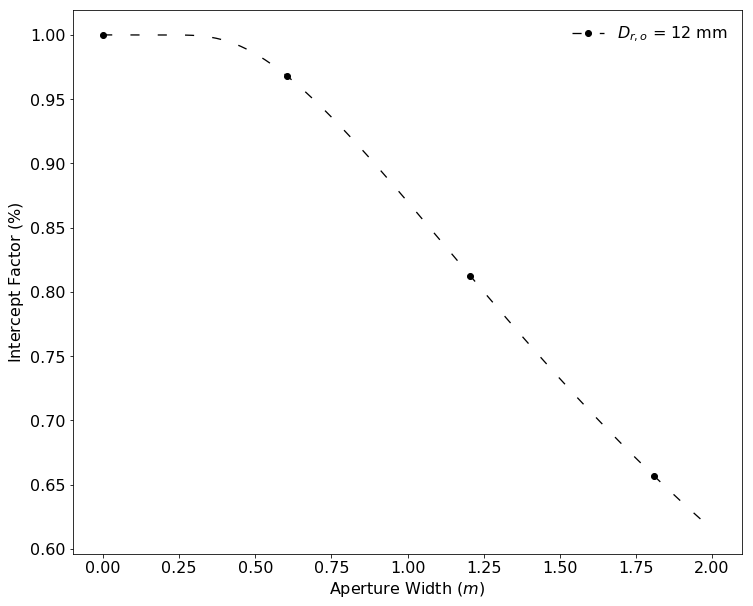

In [163]:
len = 200
Width = np.array(np.linspace(0, 2, len))
Gamma = np.zeros(len)
eta_o = np.zeros(len)
eta_t = np.zeros(len)


for i in range(len):
    Gamma[i] = InterceptFactorInputs( Width[i], D_ro, sigma_sun, sigma_slope, sigma_mirror, beta, dr, phi_r)
    eta_o[i] = OpticalEfficiency( rho_m, tau_e, alpha_r, Gamma[i], theta, A_f)
    eta_t[i] = ThermalEfficiency( eta_o[i], I, Width[i], U_l, T_r, T_a)


pyplot.figure(figsize=(12,10))
pyplot.tick_params(axis='both', labelsize=16)
pyplot.xlabel('Aperture Width $(m)$', fontsize=16)
pyplot.ylabel('Intercept Factor $(\%)$', fontsize=16)

pyplot.plot(Width, Gamma, linewidth=1.3, color = 'black', linestyle=(0, (7, 14)), marker='o', markevery=60, label="$D_{r,o}$ = 12 mm")
# pyplot.plot(Width, eta_o, linewidth=1.3, color = 'black', linestyle=(0, (1, 5)), marker='s',markevery=60, label="Optical Efficiency, $D_{r,o}$ = 12 mm")

pyplot.legend( prop={'size': 16}, frameon=False)
# pyplot.tight_layout()

pyplot.savefig('InterceptFactor_Width.png')

Plot - **Efficiency** vs **Aperture Width**

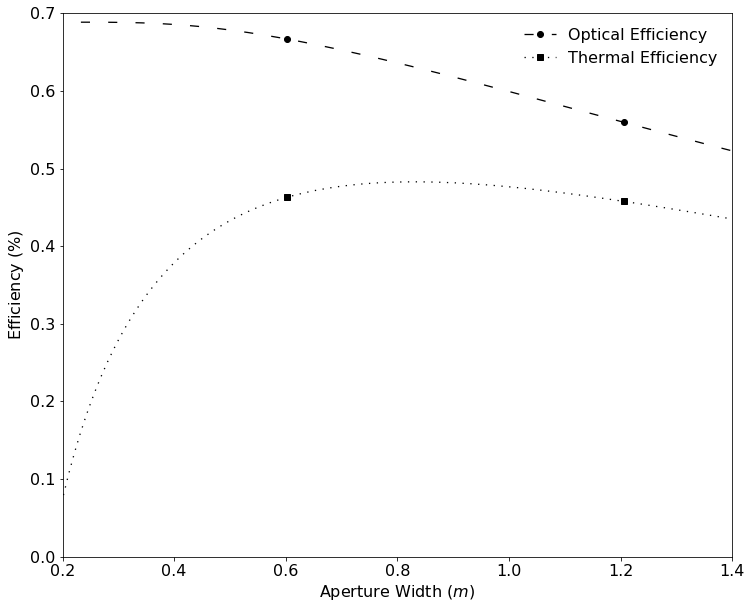

In [164]:
pyplot.figure(figsize=(12,10))
pyplot.xlim(0.2, 1.4)
pyplot.ylim(0,0.7)

pyplot.tick_params(axis='both', labelsize=16)
pyplot.xlabel('Aperture Width $(m)$', fontsize=16)
pyplot.ylabel('Efficiency $(\%)$', fontsize=16)

pyplot.plot(Width, eta_o, linewidth=1.3, color = 'black', linestyle=(0, (7, 14)), marker='o', markevery=60, label="Optical Efficiency")
pyplot.plot(Width, eta_t, linewidth=1.3, color = 'black', linestyle=(0, (1, 5)), marker='s',markevery=60, label="Thermal Efficiency")

pyplot.legend( prop={'size': 16}, frameon=False)
# pyplot.tight_layout()

pyplot.savefig('Optical and Thermal efficiency.png')

Plot - **Intercept factor** vs **Receiver Diameter**

F:\HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
F:\HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
F:\HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
F:\HOME\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


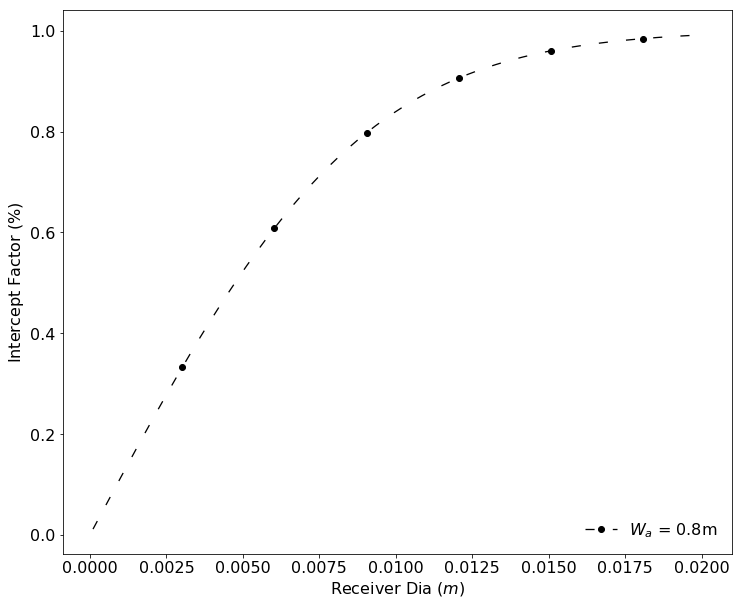

In [165]:
Dia_ro = np.array(np.linspace(0, 0.020, len))
Gamma1 = np.zeros(len)

for i in range(len):
    Gamma1[i] = InterceptFactorInputs( W_a, Dia_ro[i], sigma_sun, sigma_slope, sigma_mirror, beta, dr, phi_r)

pyplot.figure(figsize=(12,10))
pyplot.tick_params(axis='both', labelsize=16)
pyplot.xlabel('Receiver Dia $(m)$', fontsize=16)
pyplot.ylabel('Intercept Factor $(\%)$', fontsize=16)

pyplot.plot(Dia_ro, Gamma1, linewidth=1.3, color = 'black', linestyle=(0, (7, 14)), marker='o', markevery=30, label="$W_a$ = 0.8m")


pyplot.legend(loc=4, prop={'size': 16}, frameon=False)
# pyplot.tight_layout()

pyplot.savefig('InterceptFactor_Dia.png')

In [166]:
InterceptFactorInputs( 0.8, 0.0254, sigma_sun, sigma_slope, sigma_mirror, 1*np.pi/180, 0.08, phi_r)

0.057719563919515444